# Model Training

In [1]:
# Libraries

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from PIL import Image
import matplotlib.pyplot as plt
import os
import random

In [2]:
# Hyperparameters
num_epochs = 10
batch_size = 32
learning_rate = 0.001

classes = ['Apple', 'Banana', 'Orange']
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Custom transform to resize and keep the aspect ratio
class ResizeWithAspectRatio:
    def __init__(self, size):
        self.size = size  # The target size (width, height)
    
    def __call__(self, img):
        # Get the original width and height
        w, h = img.size
        target_w, target_h = self.size
        
        # Compute the scaling factor to keep the aspect ratio
        ratio_w = target_w / w
        ratio_h = target_h / h
        ratio = min(ratio_w, ratio_h)  # Use the smaller ratio to fit the image

        # Resize the image while preserving aspect ratio
        new_w = int(w * ratio)
        new_h = int(h * ratio)
        img = img.resize((new_w, new_h), Image.Resampling.LANCZOS)

        # Create a new image with the target size and paste the resized image
        new_img = Image.new("RGB", self.size, (0, 0, 0))  # Black padding
        new_img.paste(img, ((target_w - new_w) // 2, (target_h - new_h) // 2))

        return new_img
    
class RandomCrop:
    def __init__(self, max_crop_pct=0.1):
        # max_crop_pct is a percentage of the width/height of the image
        self.max_crop_pct = max_crop_pct

    def __call__(self, img):
        # Disable cropping if the image is not square
        if img.width != img.height:
            return img  # No cropping, just return the image as it is

        # Calculate max crop amount based on the percentage
        max_crop = int(img.width * self.max_crop_pct)

        # Randomly choose a crop amount
        do_crop = random.choice([True, False])

        if do_crop:
            # Crop the height randomly, keeping width unchanged
            crop_y = random.randint(0, max_crop) + img.width * 0.2
            img = img.crop((0, crop_y, img.width, img.height - crop_y))

        return img
    
transform = transforms.Compose([
    RandomCrop(),
    ResizeWithAspectRatio((64, 64)), 
    transforms.ToTensor()
    #,      
    #transforms.Normalize((0.5,), (0.5,)) # Does much better w/o normalization
])


In [3]:
class CNN(nn.Module):
    def __init__(self, classes, num_epochs=num_epochs):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1) 
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 16 * 16, 128)  # image size
        self.fc2 = nn.Linear(128, len(classes))  # n output classes 
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.num_epochs = num_epochs    

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 64 * 16 * 16) 
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

        

def train_model(model, train_loader):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    model.train()
    for epoch in range(model.num_epochs):
        total_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch [{epoch+1}/{model.num_epochs}], Loss: {total_loss/len(train_loader):.4f}")


def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Accuracy: {100 * correct / total:.2f}% ({correct} / {total})")


def visualize_predictions(model, test_loader):
    model.eval()
    images, labels = next(iter(test_loader))
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

    plt.figure(figsize=(12, 8))
    for i in range(6):
        plt.subplot(2, 3, i + 1)
        plt.imshow(images[i].permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5) 
        plt.title(f"True: {labels[i].item()}, Pred: {predicted[i].item()}")
        plt.axis('off')
    plt.show()

def visualize_incorrect(model, test_dataset, width = 4, height = 2):
    model.eval()
    loader = DataLoader(dataset=test_dataset, batch_size=len(test_dataset))
    images, labels = next(iter(loader))
    images, labels = images.to('cuda'), labels.to('cuda')
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

    plt.figure(figsize=(12, 8))
    incorrect = 0
    classes = test_dataset.classes
    for i in range(len(test_dataset)):
        if labels[i].item() == predicted[i].item():
            continue
        plt.subplot(height, width, incorrect + 1)
        plt.imshow(images[i].permute(1, 2, 0).cpu().numpy()) 
        plt.title(f"True: {classes[labels[i].item()]}, Pred: {classes[predicted[i].item()]}")
        plt.axis('off')
        incorrect += 1
        if incorrect == width * height:
            break
    plt.show()

    
    


In [4]:
# Datasets: All Original Images

train_dataset = datasets.ImageFolder(root='Datasets\\mbkinaci\\fruit-images-for-object-detection\\train', transform=transform)  
test_dataset = datasets.ImageFolder(root='Datasets\\mbkinaci\\fruit-images-for-object-detection\\test', transform=transform)   

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


In [5]:
# Model for All Original Images

model = CNN(classes)     
model.apply(init_weights)
    
train_model(model, train_loader)
evaluate_model(model, test_loader)
#visualize_predictions(model, test_loader)

c:\Users\0dps1\Desktop\539\DataSynthesizer\venv\Lib\site-packages\PIL\Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [1/10], Loss: 1.1620
Epoch [2/10], Loss: 0.8283
Epoch [3/10], Loss: 0.4880
Epoch [4/10], Loss: 0.3199
Epoch [5/10], Loss: 0.2480
Epoch [6/10], Loss: 0.2361
Epoch [7/10], Loss: 0.1674
Epoch [8/10], Loss: 0.1724
Epoch [9/10], Loss: 0.1052
Epoch [10/10], Loss: 0.0918
Accuracy: 87.27% (48 / 55)


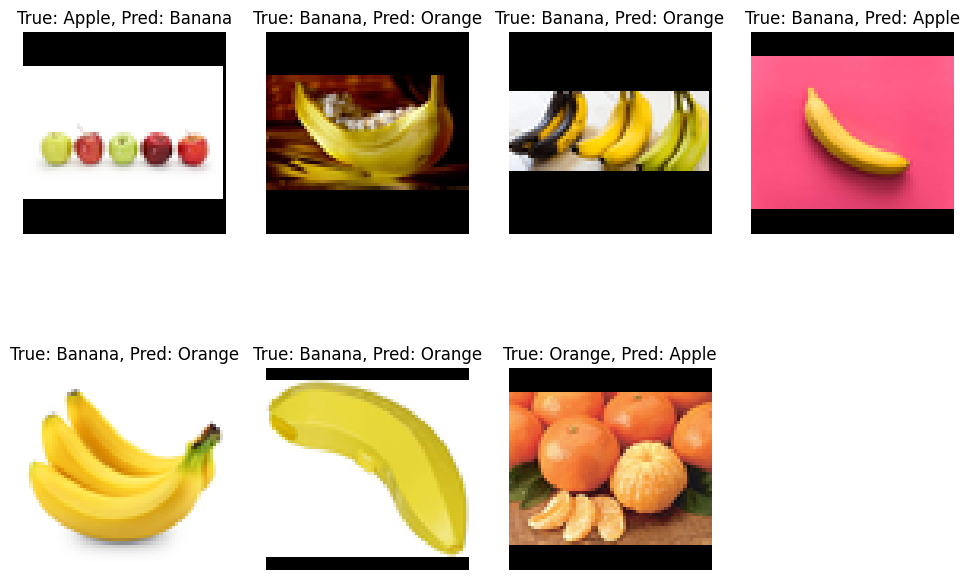

In [6]:
visualize_incorrect(model, test_dataset)

In [7]:
from typing import Dict, List, Tuple, Union
from pathlib import Path

class CustomImageFolder(datasets.ImageFolder):
    def __init__(self, root, allowed_classes, transform=None):
        self.allowed_classes = allowed_classes
        super().__init__(root=root, transform=transform)

    def find_classes(self, directory: Union[str, Path]) -> Tuple[List[str], Dict[str, int]]:
        classes, class_to_idx = super().find_classes(directory)
        classes = [class_name for class_name in classes if class_name in self.allowed_classes]
        classes.sort()
        class_to_idx = {classes[i]: i for i in range(len(classes))}
        return classes, class_to_idx

In [8]:
# Datasets: All Synthetic Images

root_dir = 'Datasets\\DiegoP-S\\DatasetSynthesis'
allowed_folders = classes
train_dataset2 = CustomImageFolder(root=root_dir, allowed_classes=allowed_folders, transform=transform)
train_loader2 = DataLoader(dataset=train_dataset2, batch_size=batch_size, shuffle=True)

print(train_dataset2.classes)


['Apple', 'Banana', 'Orange']


In [9]:
# Model for All Synthetic Images

model2 = CNN(classes)     
model2.apply(init_weights)
    
train_model(model2, train_loader2)
evaluate_model(model2, test_loader)

Epoch [1/10], Loss: 1.4560
Epoch [2/10], Loss: 1.0024
Epoch [3/10], Loss: 0.8400
Epoch [4/10], Loss: 0.6818
Epoch [5/10], Loss: 0.5219
Epoch [6/10], Loss: 0.3294
Epoch [7/10], Loss: 0.2894
Epoch [8/10], Loss: 0.1959
Epoch [9/10], Loss: 0.1638
Epoch [10/10], Loss: 0.1568
Accuracy: 74.55% (41 / 55)


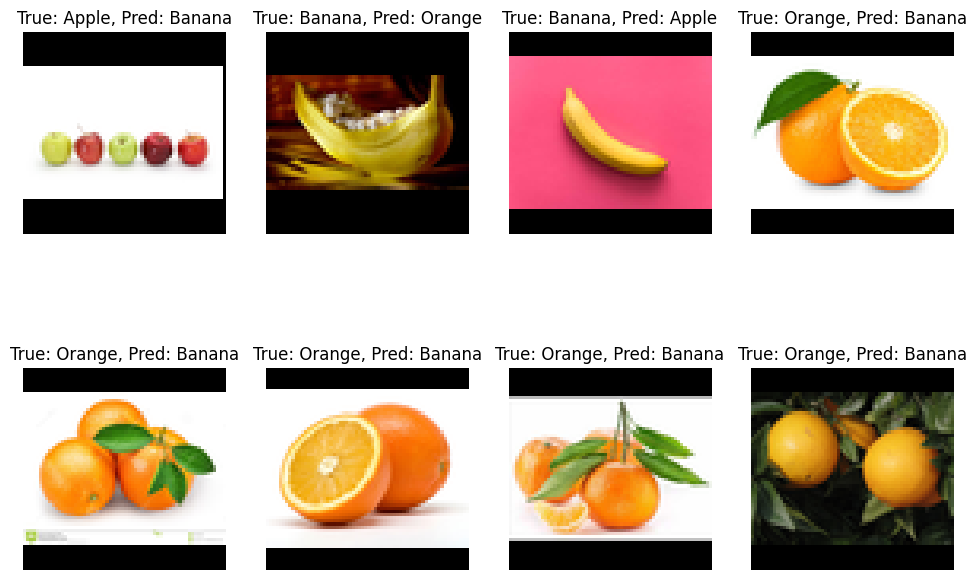

Accuracy: 80.00% (176 / 220)


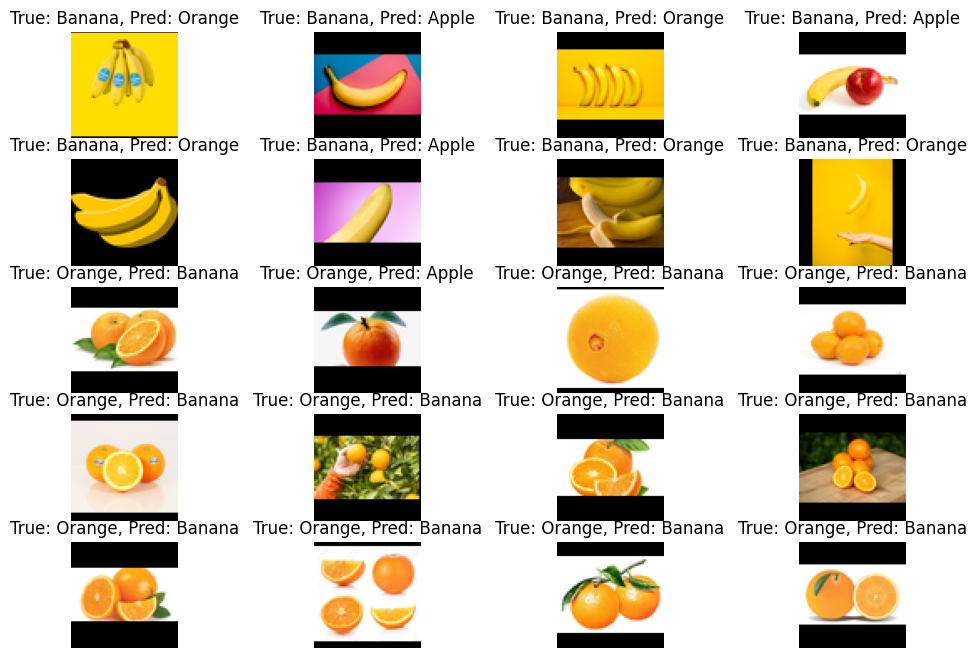

In [10]:
visualize_incorrect(model2, test_dataset)
evaluate_model(model2, train_loader)
visualize_incorrect(model2, train_dataset, height=5)


In [11]:
# Datasets: Synthetic Images 50% Original 50%

synthetic_dataset = train_dataset2
original_dataset = train_dataset

def get_class_indices(dataset):
    """Return a dictionary with class indices grouped by category."""
    class_indices = {class_name: [] for class_name in dataset.classes}
    for idx, (_, label) in enumerate(dataset.samples):
        class_name = dataset.classes[label]
        class_indices[class_name].append(idx)
    return class_indices

synthetic_indices = get_class_indices(synthetic_dataset)
original_indices = get_class_indices(original_dataset)

print(synthetic_indices)
print(original_indices)

def sample_indices(synthetic_indices, original_indices, syn_ratio=0.5, orig_ratio=0.5):
    combined_indices = []
    for category in synthetic_indices.keys():
        syn_count = int(len(synthetic_indices[category]) * syn_ratio)
        orig_count = int(len(original_indices[category]) * orig_ratio)

        syn_sample = random.sample(synthetic_indices[category], min(syn_count, len(synthetic_indices[category])))
        orig_sample = random.sample(original_indices[category], min(orig_count, len(original_indices[category])))

        combined_indices.extend(syn_sample + orig_sample)

    return combined_indices

combined_indices = sample_indices(synthetic_indices, original_indices)


combined_dataset = Subset(synthetic_dataset + original_dataset, combined_indices)
train_loader3 = DataLoader(combined_dataset, batch_size=32, shuffle=True)



{'Apple': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99], 'Banana': [100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199], 'Orange': [200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 

In [14]:
# Model for Synthetic Images 50% Original 50%

model3 = CNN(classes, num_epochs=20)     
model3.apply(init_weights)
    
train_model(model3, train_loader3)
evaluate_model(model3, test_loader)

Epoch [1/20], Loss: 1.0947
Epoch [2/20], Loss: 0.8609
Epoch [3/20], Loss: 0.6344
Epoch [4/20], Loss: 0.3730
Epoch [5/20], Loss: 0.3262
Epoch [6/20], Loss: 0.2556
Epoch [7/20], Loss: 0.2110
Epoch [8/20], Loss: 0.3079
Epoch [9/20], Loss: 0.1637
Epoch [10/20], Loss: 0.1422
Epoch [11/20], Loss: 0.1289
Epoch [12/20], Loss: 0.1081
Epoch [13/20], Loss: 0.0902
Epoch [14/20], Loss: 0.0628
Epoch [15/20], Loss: 0.0511
Epoch [16/20], Loss: 0.0468
Epoch [17/20], Loss: 0.0326
Epoch [18/20], Loss: 0.0292
Epoch [19/20], Loss: 0.0228
Epoch [20/20], Loss: 0.0206
Accuracy: 89.09% (49 / 55)


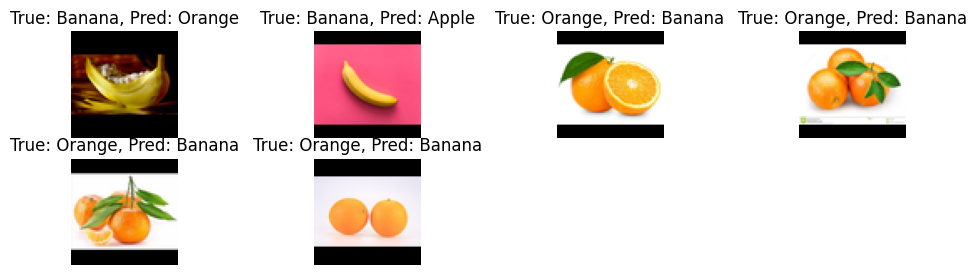

Accuracy: 80.91% (178 / 220)


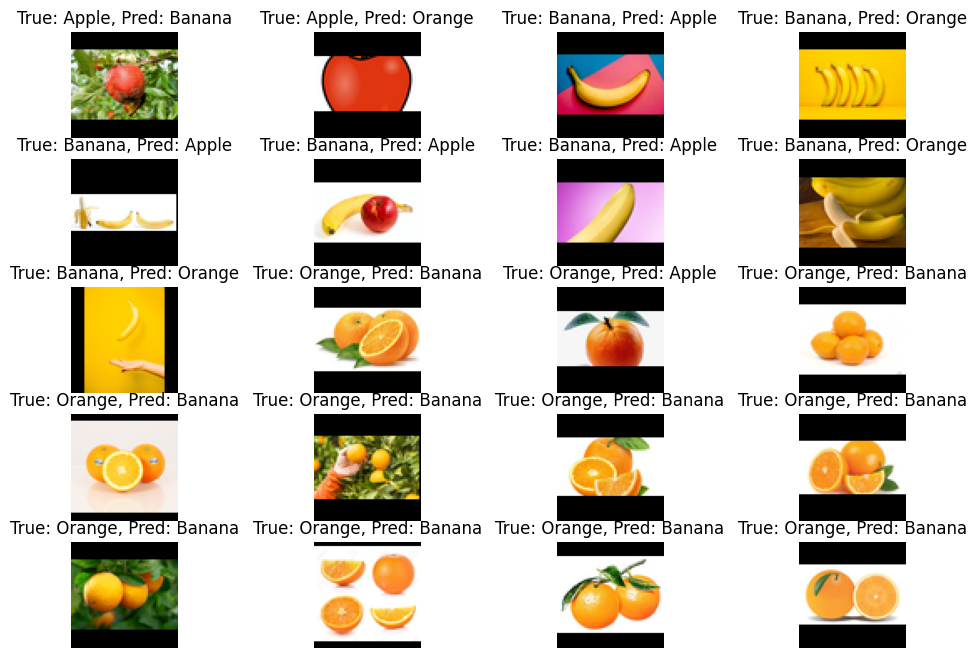

In [15]:
visualize_incorrect(model3, test_dataset, height=5)
evaluate_model(model3, train_loader)
visualize_incorrect(model3, train_dataset, height=5)



In [139]:
# 70 % Synthetic 30% Original

combined_indices = sample_indices(synthetic_indices, original_indices, syn_ratio=0.7, orig_ratio=0.3)

combined_dataset = Subset(synthetic_dataset + original_dataset, combined_indices)
train_loader4 = DataLoader(combined_dataset, batch_size=32, shuffle=True)

In [140]:
# Model for 70 % Synthetic 30% Original

model4 = CNN(classes)     
model4.apply(init_weights)
    
train_model(model4, train_loader4)
evaluate_model(model4, test_loader)

Epoch [1/10], Loss: 1.2924
Epoch [2/10], Loss: 1.0175
Epoch [3/10], Loss: 0.8693
Epoch [4/10], Loss: 0.6203
Epoch [5/10], Loss: 0.4280
Epoch [6/10], Loss: 0.2348
Epoch [7/10], Loss: 0.1730
Epoch [8/10], Loss: 0.1549
Epoch [9/10], Loss: 0.0968
Epoch [10/10], Loss: 0.0713
Accuracy: 89.09% (49 / 55)


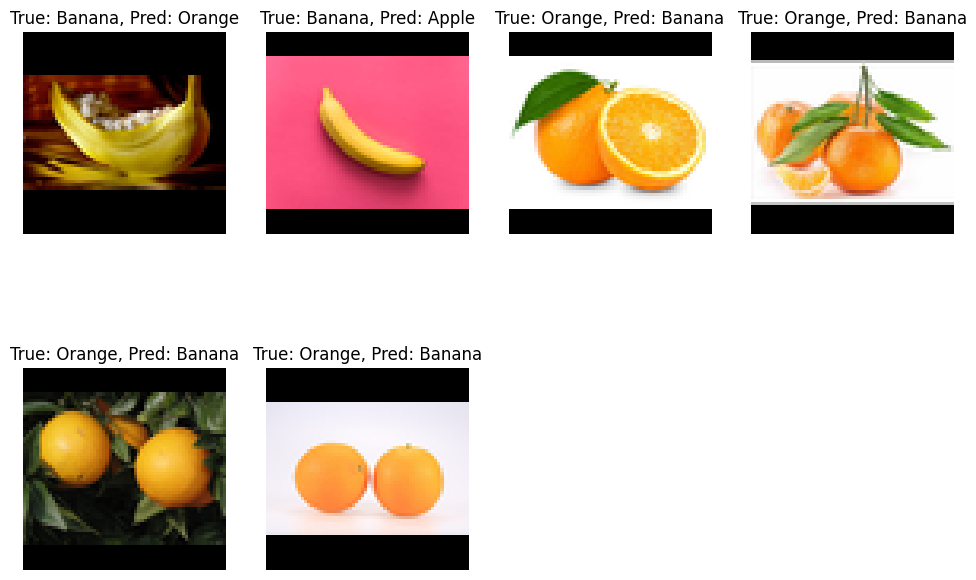

Accuracy: 85.00% (187 / 220)


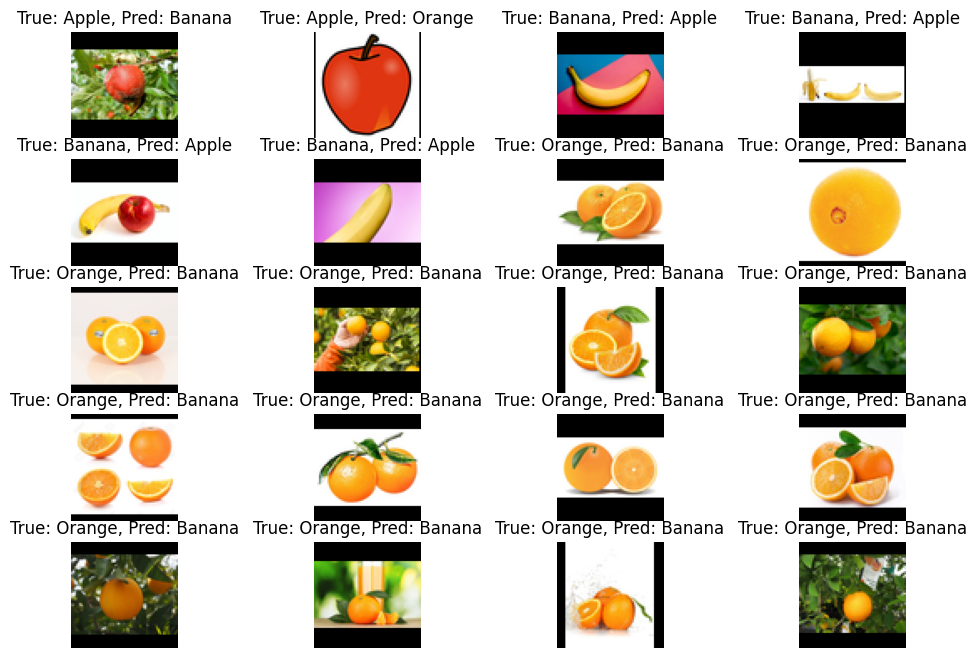

In [141]:
visualize_incorrect(model4, test_dataset)
evaluate_model(model4, train_loader)
visualize_incorrect(model4, train_dataset, height=5)

